# Рекомендательные системы

## Данные
Посмотрим какие у нас данные и немного проанализируем их

In [69]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
%matplotlib inline

from rectools import Columns
from rectools.dataset import Dataset
from rectools.models import LightFMWrapperModel, PureSVDModel, ImplicitItemKNNWrapperModel
from lightfm import LightFM
from implicit.nearest_neighbours import CosineRecommender
from rectools.model_selection import RandomSplitter, TimeRangeSplitter, cross_validate
from rectools.metrics import F1Beta
from tqdm import tqdm
from scipy import sparse

In [70]:
df = pd.read_csv('train.csv')

In [71]:
def get_unique_count(x):
    return len(np.unique(x))
print("Количество покупателей: ", len(df.groupby("user_id").aggregate(get_unique_count)))
print("Количество товаров: ", len(df.groupby("cart").aggregate(get_unique_count)))

Количество покупателей:  20000
Количество товаров:  881


Посмотрим распределение покупок товаров:

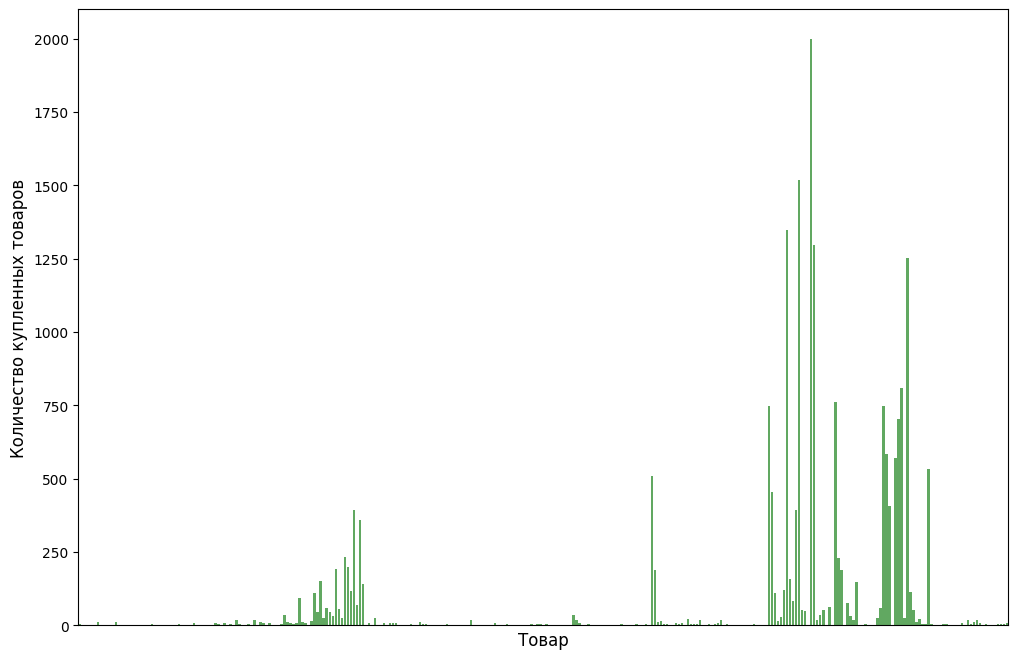

In [72]:
cnt_srs = df.groupby("user_id")["cart"].aggregate("max").reset_index()
cnt_srs = cnt_srs.cart.value_counts()
plt.figure(figsize=(12,8))
sns.barplot(x=cnt_srs.index, y=cnt_srs.values, alpha=0.8, color=color[2])
plt.ylabel('Количество купленных товаров', fontsize=12)
plt.xlabel('Товар', fontsize=12)
plt.xticks([])
plt.show()

Посмотрим на зависимость частоты покупок и их размеров, т.е. какие по размеру "корзины" в нашем магазине чаще покупают

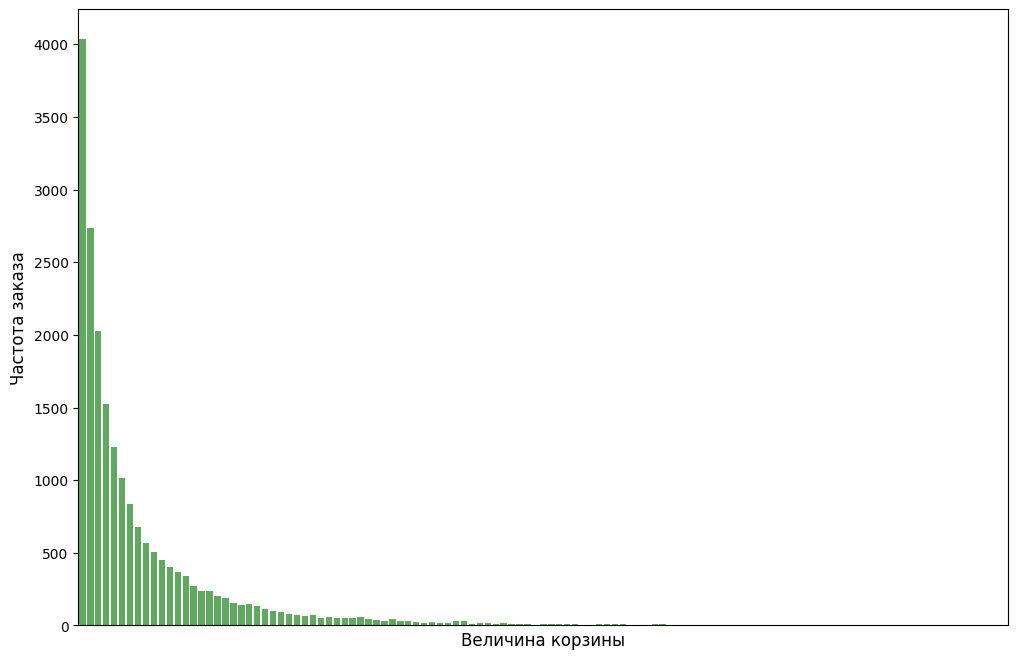

In [73]:
cnt_srs = df.groupby("user_id").aggregate(get_unique_count)
cnt_srs = cnt_srs.order_completed_at.value_counts()

plt.figure(figsize=(12,8))
sns.barplot(x=cnt_srs.index, y=cnt_srs.values, alpha=0.8, color=color[2])
plt.ylabel('Частота заказа', fontsize=12)
plt.xlabel('Величина корзины', fontsize=12)
plt.xticks([])
plt.show()

Не факт, что в submission надо всех пользователей, ведь есть дата отсечки, до которой некоторые пользователи заказы не сделали, так что возьмем именно тех, кто есть в sample_submission:

In [74]:
def user_order_split(text):
    return text.split(sep=';')
sample_df = pd.read_csv('sample_submission.csv')
sample_users_orders = sample_df["id"].apply(user_order_split)
users = [int(data[0]) for data in sample_users_orders.to_numpy()] 
orders = [int(data[1]) for data in sample_users_orders.to_numpy()]
users = list(set(users))
orders = list(set(orders))
df_testtrain = df.loc[df['cart'].isin(orders)]
df_testtrain = df.loc[df['user_id'].isin(users)]
df_testtrain.reset_index(drop=True, inplace=True)

Теперь разделим наши данные на тестовую и тренировочные выборки(в тестовую засунем все последние заказы, в тренировочные остальное):

In [75]:
last_orderdates = df_testtrain.groupby('user_id', as_index=False).order_completed_at.max()

In [76]:
df_merged = df_testtrain.merge(last_orderdates.drop_duplicates(), how='left', indicator=True)

в тест последние заказы:

In [77]:
df_test = df_testtrain[df_merged['_merge'] == "both"]
df_test.reset_index(drop=True, inplace=True)

In [78]:
df_merged = df_testtrain.merge(df_test.drop_duplicates(), how='left', indicator=True)

в трейн все остальное:

In [79]:
df_train = df_testtrain[df_merged['_merge'] == 'left_only']
df_train.reset_index(drop=True, inplace=True)

## Модели

Для начала протестим несколько моделей на случайном разбиении данных, посмотрим какую лучше выбрать без учета фич.

In [80]:
models = {
    "LightFM": LightFMWrapperModel(model=LightFM(k=10, no_components=32, loss = "warp"), epochs=20),
    "PureSVD": PureSVDModel(factors=100),
    "CosRec": ImplicitItemKNNWrapperModel(model=CosineRecommender(K=20))
}
randsplitter = RandomSplitter(
    test_fold_frac=0.2,
    n_splits=3,
    filter_cold_items=False,
    filter_already_seen=False,
    filter_cold_users=False
)
timesplitter = TimeRangeSplitter(
    test_size="1D",
    n_splits=1,
    filter_cold_items=False,
    filter_already_seen=False,
    filter_cold_users=False
)
metrics = {
    "F1Beta": F1Beta(k=10)
}

In [84]:
full_data = df_testtrain.rename(columns={"user_id" : Columns.User, "order_completed_at" : Columns.Datetime, "cart":Columns.Item})
full_data[Columns.Weight] = 1
full_data[Columns.Weight] = full_data.groupby([Columns.User, Columns.Item]).transform("sum")
fulldataset = Dataset.construct(full_data)


In [85]:
cv_results = cross_validate(
    dataset=fulldataset,
    splitter=randsplitter,
    models=models,
    metrics=metrics,
    k=10,
    filter_viewed=False,
)

In [86]:
pd.DataFrame(cv_results['metrics'])

,model,i_split,F1Beta
0,LightFM,0,0.333514
1,PureSVD,0,0.424945
2,CosRec,0,0.338786
3,LightFM,1,0.338507
4,PureSVD,1,0.428819
5,CosRec,1,0.338244
6,LightFM,2,0.336188
7,PureSVD,2,0.424503
8,CosRec,2,0.341118


In [87]:
cv_results = cross_validate(
    dataset=fulldataset,
    splitter=timesplitter,
    models=models,
    metrics=metrics,
    k=10,
    filter_viewed=False,
)

In [88]:
pd.DataFrame(cv_results['metrics'])

,model,i_split,F1Beta
0,LightFM,0,0.280290
1,PureSVD,0,0.399469
2,CosRec,0,0.302335


In [89]:
model = PureSVDModel(factors=170)
model.fit(fulldataset)
recos = model.recommend(
    users=users,
    dataset=fulldataset,
    k = 10,
    items_to_recommend=orders,
    filter_viewed=False
)

Как видно, для случайного разбиения SVD модель показывает себя лучше, оно и ясно, никаких features у наших данных нет, matrix factorization и все, никаких эмбеддингов для фич и т.п. :(

In [91]:
'''
targets = []
for row in tqdm(sample_df['id']):
    user, item = map(int, row.split(sep=';'))
    if item in list(recos[recos['user_id'] == user]['item_id']):
        target = 1
    else:
        target = 0
    targets.append(target)
submit = sample_df.drop(columns='target', axis=0)
submit['target'] = targets
submit.to_csv("SVDsubmit.csv", index=False)
'''

'\ntargets = []\nfor row in tqdm(sample_df[\'id\']):\n    user, item = map(int, row.split(sep=\';\'))\n    if item in list(recos[recos[\'user_id\'] == user][\'item_id\']):\n        target = 1\n    else:\n        target = 0\n    targets.append(target)\nsubmit = sample_df.drop(columns=\'target\', axis=0)\nsubmit[\'target\'] = targets\nsubmit.to_csv("SVDsubmit.csv", index=False)\n'

## Рассмотрим ligthFM поближе

In [92]:
train_data = df_train.rename(columns={"user_id" : Columns.User, "order_completed_at" : Columns.Datetime, "cart":Columns.Item})
test_data = df_test.rename(columns={"user_id" : Columns.User, "order_completed_at" : Columns.Datetime, "cart":Columns.Item})
train_data[Columns.Weight] = 1
test_data[Columns.Weight] = 1

In [93]:
train_data[Columns.Weight] = train_data.groupby([Columns.User, Columns.Item]).transform(lambda x: x/x.sum())

Для lightFM удобно сделать feature engineering, даже из такого скудного датасета, можно выявить что-то интересное.

In [94]:
train_data["orders_total"] = 1
train_data["orders_total"] = train_data.groupby('user_id').orders_total.transform("sum")
train_data["total_ordered"] = 1
train_data["total_ordered"] = train_data.groupby('item_id').total_ordered.transform("sum")

In [95]:
user_feat = train_data[['user_id', 'orders_total']]
user_feat.drop_duplicates(inplace=True)
user_feat.reset_index(drop=True, inplace=True)

In [22]:
item_feat = train_data[['item_id', 'total_ordered']]
item_feat.drop_duplicates(inplace=True)
item_feat.reset_index(drop=True, inplace=True)

In [96]:
user_features_frames = []
for feature in ['orders_total']:
    feature_frame = user_feat.reindex(columns=[Columns.User, feature])
    feature_frame.columns = ["id", "value"]
    feature_frame["feature"] = feature
    user_features_frames.append(feature_frame)
user_features = pd.concat(user_features_frames)

In [97]:
item_features_frames = []
for feature in ['total_ordered']:
    feature_frame = item_feat.reindex(columns=[Columns.Item, feature])
    feature_frame.columns = ["id", "value"]
    feature_frame["feature"] = feature
    item_features_frames.append(feature_frame)
item_features = pd.concat(item_features_frames)

In [98]:
dataset = Dataset.construct(
    train_data,
    user_features_df=user_features,
    cat_user_features=["orders_total"],
    item_features_df=item_features,
    cat_item_features=['total_ordered']
)

In [99]:
model = LightFMWrapperModel(LightFM(no_components=32, loss="warp"), epochs=6)
model.fit(dataset)
recos = model.recommend(
    users=users,
    dataset=dataset,
    k = 10,
    items_to_recommend=orders,
    filter_viewed=False
)

In [106]:
'''
targets = []
for row in tqdm(sample_df['id']):
    user, item = map(int, row.split(sep=';'))
    if item in list(recos[recos['user_id'] == user]['item_id']):
        target = 1
    else:
        target = 0
    targets.append(target)
submit = sample_df.drop(columns='target', axis=0)
submit['target'] = targets
submit.to_csv("LightFMsubmit.csv", index=False)
'''


'\ntargets = []\nfor row in tqdm(sample_df[\'id\']):\n    user, item = map(int, row.split(sep=\';\'))\n    if item in list(recos[recos[\'user_id\'] == user][\'item_id\']):\n        target = 1\n    else:\n        target = 0\n    targets.append(target)\nsubmit = sample_df.drop(columns=\'target\', axis=0)\nsubmit[\'target\'] = targets\nsubmit.to_csv("LightFMsubmit.csv", index=False)\n'